# Image generation with Stable Diffusion v3 and OpenVINO

Stable Diffusion V3 is next generation of latent diffusion image Stable Diffusion models family that  outperforms state-of-the-art text-to-image generation systems in typography and prompt adherence, based on human preference evaluations. In comparison with previous versions, it based on Multimodal Diffusion Transformer (MMDiT) text-to-image model that features greatly improved performance in image quality, typography, complex prompt understanding, and resource-efficiency.

![mmdit.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/dd079427-89f2-4d28-a10e-c80792d750bf)

More details about model can be found in [model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium), [research paper](https://stability.ai/news/stable-diffusion-3-research-paper) and [Stability.AI blog post](https://stability.ai/news/stable-diffusion-3-medium).
In this tutorial, we will consider how to convert Stable Diffusion v3 for running with OpenVINO. An additional part demonstrates how to run optimization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.
If you want to run previous Stable Diffusion versions, please check our other notebooks:

* [Stable Diffusion](../stable-diffusion-text-to-image)
* [Stable Diffusion v2](../stable-diffusion-v2)
* [Stable Diffusion XL](../stable-diffusion-xl)
* [LCM Stable Diffusion](../latent-consistency-models-image-generation)
* [Turbo SDXL](../sdxl-turbo)
* [Turbo SD](../sketch-to-image-pix2pix-turbo)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Build PyTorch pipeline](#Build-PyTorch-pipeline)
- [Convert models with OpenVINO](#Convert-models-with-OpenVINO)
    - [Transformer](#Transformer)
    - [T5 Text Encoder](#T5-Text-Encoder)
    - [Clip text encoders](#Clip-text-encoders)
    - [VAE](#VAE)
- [Prepare OpenVINO inference pipeline](#Prepare-OpenVINO-inference-pipeline)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run Quantization](#Run-Quantization)
    - [Run Weights Compression](#Run-Weights-Compression)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and optimized pipelines](#Compare-inference-time-of-the-FP16-and-optimized-pipelines)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-v3/stable-diffusion-v3.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "git+https://github.com/initml/diffusers.git@clement/feature/flash_sd3" "gradio>=4.19" "torch>=2.1"  "transformers" "nncf>=2.11.0" "datasets>=2.14.6" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU --pre  "openvino>=2024.2.0" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly

## Build PyTorch pipeline
[back to top ⬆️](#Table-of-contents:)

>**Note**: run model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium-diffusers), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [2]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

We will use [Diffusers](https://huggingface.co/docs/diffusers/main/en/index) library integration for running Stable Diffusion v3 model. You can find more details in Diffusers [documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_3).
Additionally, we can apply optimization for pipeline performance and memory consumption:

* **Use flash SD3**. Flash Diffusion is a diffusion distillation method proposed in [Flash Diffusion: Accelerating Any Conditional Diffusion Model for Few Steps Image Generation](http://arxiv.org/abs/2406.02347). The model represented as a 90.4M LoRA distilled version of SD3 model that is able to generate 1024x1024 images in 4 steps. If you want disable it, you can unset checkbox **Use flash SD3**
* **Remove T5 text encoder**. Removing the memory-intensive 4.7B parameter T5-XXL text encoder during inference can significantly decrease the memory requirements for SD3 with only a slight loss in performance. If you want to use this model in pipeline, please set **use t5 text encoder** checkbox.

In [3]:
import ipywidgets as widgets

use_flash_lora = widgets.Checkbox(
    value=True,
    description="Use flash SD3",
    disabled=False,
)

load_t5 = widgets.Checkbox(
    value=False,
    description="Use t5 text encoder",
    disabled=False,
)

pt_pipeline_options = widgets.VBox([use_flash_lora, load_t5])
display(pt_pipeline_options)

In [ ]:
from pathlib import Path
import torch
from diffusers import StableDiffusion3Pipeline, SD3Transformer2DModel
from peft import PeftModel


MODEL_DIR = Path("stable-diffusion-3")
MODEL_DIR.mkdir(exist_ok=True)

TRANSFORMER_PATH = MODEL_DIR / "transformer.xml"
VAE_DECODER_PATH = MODEL_DIR / "vae_decoder.xml"
TEXT_ENCODER_PATH = MODEL_DIR / "text_encoder.xml"
TEXT_ENCODER_2_PATH = MODEL_DIR / "text_encoder_2.xml"
TEXT_ENCODER_3_PATH = MODEL_DIR / "text_encoder_3.xml"

conversion_statuses = [TRANSFORMER_PATH.exists(), VAE_DECODER_PATH.exists(), TEXT_ENCODER_PATH.exists(), TEXT_ENCODER_2_PATH.exists()]

if load_t5.value:
    conversion_statuses.append(TEXT_ENCODER_3_PATH.exists())

requires_conversion = not all(conversion_statuses)

transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = None, None, None, None, None


def get_pipeline_components():
    pipe_kwargs = {}
    if use_flash_lora.value:
        # Load LoRA
        transformer = SD3Transformer2DModel.from_pretrained(
            "stabilityai/stable-diffusion-3-medium-diffusers",
            subfolder="transformer",
        )
        transformer = PeftModel.from_pretrained(transformer, "jasperai/flash-sd3")
        pipe_kwargs["transformer"] = transformer
    if not load_t5.value:
        pipe_kwargs.update({"text_encoder_3": None, "tokenizer_3": None})
    pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", **pipe_kwargs)
    pipe.tokenizer.save_pretrained(MODEL_DIR / "tokenizer")
    pipe.tokenizer_2.save_pretrained(MODEL_DIR / "tokenizer_2")
    if load_t5.value:
        pipe.tokenizer_3.save_pretrained(MODEL_DIR / "tokenizer_3")
    pipe.scheduler.save_pretrained(MODEL_DIR / "scheduler")
    transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = None, None, None, None, None
    if not TRANSFORMER_PATH.exists():
        transformer = pipe.transformer
        transformer.eval()
    if not VAE_DECODER_PATH.exists():
        vae = pipe.vae
        vae.eval()
    if not TEXT_ENCODER_PATH.exists():
        text_encoder = pipe.text_encoder
        text_encoder.eval()
    if not TEXT_ENCODER_2_PATH.exists():
        text_encoder_2 = pipe.text_encoder_2
        text_encoder_2.eval()
    if not TEXT_ENCODER_3_PATH.exists() and load_t5.value:
        text_encoder_3 = pipe.text_encoder_3
        text_encoder_3.eval()
    return transformer, vae, text_encoder, text_encoder_2, text_encoder_3


if requires_conversion:
    transformer, vae, text_encoder, text_encoder_2, text_encoder_3 = get_pipeline_components()

## Convert models with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### Transformer
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import openvino as ov
from functools import partial
import gc


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


class TransformerWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, hidden_states, encoder_hidden_states, pooled_projections, timestep, return_dict=False):
        return self.model(
            hidden_states=hidden_states,
            encoder_hidden_states=encoder_hidden_states,
            pooled_projections=pooled_projections,
            timestep=timestep,
            return_dict=return_dict,
        )


if not TRANSFORMER_PATH.exists():
    if isinstance(transformer, PeftModel):
        transformer = TransformerWrapper(transformer)
    transformer.forward = partial(transformer.forward, return_dict=False)

    with torch.no_grad():
        ov_model = ov.convert_model(
            transformer,
            example_input={
                "hidden_states": torch.zeros((2, 16, 64, 64)),
                "timestep": torch.tensor([1, 1]),
                "encoder_hidden_states": torch.ones([2, 154, 4096]),
                "pooled_projections": torch.ones([2, 2048]),
            },
        )
    ov.save_model(ov_model, TRANSFORMER_PATH)
    del ov_model
    cleanup_torchscript_cache()

del transformer
gc.collect()

### T5 Text Encoder
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not TEXT_ENCODER_3_PATH.exists() and load_t5.value:
    with torch.no_grad():
        ov_model = ov.convert_model(text_encoder_3, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_3_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder_3
gc.collect()

### Clip text encoders
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not TEXT_ENCODER_PATH.exists():
    with torch.no_grad():
        text_encoder.forward = partial(text_encoder.forward, output_hidden_states=True, return_dict=False)
        ov_model = ov.convert_model(text_encoder, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder
gc.collect()

In [ ]:
if not TEXT_ENCODER_2_PATH.exists():
    with torch.no_grad():
        text_encoder_2.forward = partial(text_encoder_2.forward, output_hidden_states=True, return_dict=False)
        ov_model = ov.convert_model(text_encoder_2, example_input=torch.ones([1, 77], dtype=torch.long))
    ov.save_model(ov_model, TEXT_ENCODER_2_PATH)
    del ov_model
    cleanup_torchscript_cache()

del text_encoder_2
gc.collect()

### VAE
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not VAE_DECODER_PATH.exists():
    with torch.no_grad():
        vae.forward = vae.decode
        ov_model = ov.convert_model(vae, example_input=torch.ones([1, 16, 64, 64]))
    ov.save_model(ov_model, VAE_DECODER_PATH)

del vae
gc.collect()

## Prepare OpenVINO inference pipeline
[back to top ⬆️](#Table-of-contents:)

In [10]:
import inspect
from typing import Callable, Dict, List, Optional, Union

import torch
from transformers import (
    CLIPTextModelWithProjection,
    CLIPTokenizer,
    T5EncoderModel,
    T5TokenizerFast,
)

from diffusers.image_processor import VaeImageProcessor
from diffusers.models.autoencoders import AutoencoderKL
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from diffusers.utils import (
    logging,
)
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion_3.pipeline_output import StableDiffusion3PipelineOutput


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    """
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps


class OVStableDiffusion3Pipeline(DiffusionPipeline):
    r"""
    Args:
        transformer ([`SD3Transformer2DModel`]):
            Conditional Transformer (MMDiT) architecture to denoise the encoded image latents.
        scheduler ([`FlowMatchEulerDiscreteScheduler`]):
            A scheduler to be used in combination with `transformer` to denoise the encoded image latents.
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModelWithProjection`]):
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModelWithProjection),
            specifically the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant,
            with an additional added projection layer that is initialized with a diagonal matrix with the `hidden_size`
            as its dimension.
        text_encoder_2 ([`CLIPTextModelWithProjection`]):
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModelWithProjection),
            specifically the
            [laion/CLIP-ViT-bigG-14-laion2B-39B-b160k](https://huggingface.co/laion/CLIP-ViT-bigG-14-laion2B-39B-b160k)
            variant.
        text_encoder_3 ([`T5EncoderModel`]):
            Frozen text-encoder. Stable Diffusion 3 uses
            [T5](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5EncoderModel), specifically the
            [t5-v1_1-xxl](https://huggingface.co/google/t5-v1_1-xxl) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_2 (`CLIPTokenizer`):
            Second Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_3 (`T5TokenizerFast`):
            Tokenizer of class
            [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer).
    """

    _optional_components = []
    _callback_tensor_inputs = ["latents", "prompt_embeds", "negative_prompt_embeds", "negative_pooled_prompt_embeds"]

    def __init__(
        self,
        transformer: SD3Transformer2DModel,
        scheduler: FlowMatchEulerDiscreteScheduler,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModelWithProjection,
        tokenizer: CLIPTokenizer,
        text_encoder_2: CLIPTextModelWithProjection,
        tokenizer_2: CLIPTokenizer,
        text_encoder_3: T5EncoderModel,
        tokenizer_3: T5TokenizerFast,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            text_encoder_2=text_encoder_2,
            text_encoder_3=text_encoder_3,
            tokenizer=tokenizer,
            tokenizer_2=tokenizer_2,
            tokenizer_3=tokenizer_3,
            transformer=transformer,
            scheduler=scheduler,
        )
        self.vae_scale_factor = 2**3
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.tokenizer_max_length = self.tokenizer.model_max_length if hasattr(self, "tokenizer") and self.tokenizer is not None else 77
        self.vae_scaling_factor = 1.5305
        self.vae_shift_factor = 0.0609
        self.default_sample_size = 64

    def _get_t5_prompt_embeds(
        self,
        prompt: Union[str, List[str]] = None,
        num_images_per_prompt: int = 1,
    ):
        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        if self.text_encoder_3 is None:
            return torch.zeros(
                (batch_size, self.tokenizer_max_length, 4096),
            )

        text_inputs = self.tokenizer_3(
            prompt,
            padding="max_length",
            max_length=self.tokenizer_max_length,
            truncation=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = torch.from_numpy(self.text_encoder_3(text_input_ids)[0])
        _, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds

    def _get_clip_prompt_embeds(
        self,
        prompt: Union[str, List[str]],
        num_images_per_prompt: int = 1,
        clip_skip: Optional[int] = None,
        clip_model_index: int = 0,
    ):
        clip_tokenizers = [self.tokenizer, self.tokenizer_2]
        clip_text_encoders = [self.text_encoder, self.text_encoder_2]

        tokenizer = clip_tokenizers[clip_model_index]
        text_encoder = clip_text_encoders[clip_model_index]

        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        text_inputs = tokenizer(prompt, padding="max_length", max_length=self.tokenizer_max_length, truncation=True, return_tensors="pt")

        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids)
        pooled_prompt_embeds = torch.from_numpy(prompt_embeds[0])
        hidden_states = list(prompt_embeds.values())[1:]

        if clip_skip is None:
            prompt_embeds = torch.from_numpy(hidden_states[-2])
        else:
            prompt_embeds = torch.from_numpy(hidden_states[-(clip_skip + 2)])

        _, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt, 1)
        pooled_prompt_embeds = pooled_prompt_embeds.view(batch_size * num_images_per_prompt, -1)

        return prompt_embeds, pooled_prompt_embeds

    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        prompt_2: Union[str, List[str]],
        prompt_3: Union[str, List[str]],
        num_images_per_prompt: int = 1,
        do_classifier_free_guidance: bool = True,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        negative_prompt_3: Optional[Union[str, List[str]]] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        clip_skip: Optional[int] = None,
    ):
        prompt = [prompt] if isinstance(prompt, str) else prompt
        if prompt is not None:
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2

            prompt_3 = prompt_3 or prompt
            prompt_3 = [prompt_3] if isinstance(prompt_3, str) else prompt_3

            prompt_embed, pooled_prompt_embed = self._get_clip_prompt_embeds(
                prompt=prompt,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=clip_skip,
                clip_model_index=0,
            )
            prompt_2_embed, pooled_prompt_2_embed = self._get_clip_prompt_embeds(
                prompt=prompt_2,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=clip_skip,
                clip_model_index=1,
            )
            clip_prompt_embeds = torch.cat([prompt_embed, prompt_2_embed], dim=-1)

            t5_prompt_embed = self._get_t5_prompt_embeds(
                prompt=prompt_3,
                num_images_per_prompt=num_images_per_prompt,
            )

            clip_prompt_embeds = torch.nn.functional.pad(clip_prompt_embeds, (0, t5_prompt_embed.shape[-1] - clip_prompt_embeds.shape[-1]))

            prompt_embeds = torch.cat([clip_prompt_embeds, t5_prompt_embed], dim=-2)
            pooled_prompt_embeds = torch.cat([pooled_prompt_embed, pooled_prompt_2_embed], dim=-1)

        if do_classifier_free_guidance and negative_prompt_embeds is None:
            negative_prompt = negative_prompt or ""
            negative_prompt_2 = negative_prompt_2 or negative_prompt
            negative_prompt_3 = negative_prompt_3 or negative_prompt

            # normalize str to list
            negative_prompt = batch_size * [negative_prompt] if isinstance(negative_prompt, str) else negative_prompt
            negative_prompt_2 = batch_size * [negative_prompt_2] if isinstance(negative_prompt_2, str) else negative_prompt_2
            negative_prompt_3 = batch_size * [negative_prompt_3] if isinstance(negative_prompt_3, str) else negative_prompt_3

            if prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !=" f" {type(prompt)}.")
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )

            negative_prompt_embed, negative_pooled_prompt_embed = self._get_clip_prompt_embeds(
                negative_prompt,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=None,
                clip_model_index=0,
            )
            negative_prompt_2_embed, negative_pooled_prompt_2_embed = self._get_clip_prompt_embeds(
                negative_prompt_2,
                num_images_per_prompt=num_images_per_prompt,
                clip_skip=None,
                clip_model_index=1,
            )
            negative_clip_prompt_embeds = torch.cat([negative_prompt_embed, negative_prompt_2_embed], dim=-1)

            t5_negative_prompt_embed = self._get_t5_prompt_embeds(prompt=negative_prompt_3, num_images_per_prompt=num_images_per_prompt)

            negative_clip_prompt_embeds = torch.nn.functional.pad(
                negative_clip_prompt_embeds,
                (0, t5_negative_prompt_embed.shape[-1] - negative_clip_prompt_embeds.shape[-1]),
            )

            negative_prompt_embeds = torch.cat([negative_clip_prompt_embeds, t5_negative_prompt_embed], dim=-2)
            negative_pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embed, negative_pooled_prompt_2_embed], dim=-1)

        return prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds

    def check_inputs(
        self,
        prompt,
        prompt_2,
        prompt_3,
        height,
        width,
        negative_prompt=None,
        negative_prompt_2=None,
        negative_prompt_3=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        pooled_prompt_embeds=None,
        negative_pooled_prompt_embeds=None,
        callback_on_step_end_tensor_inputs=None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if callback_on_step_end_tensor_inputs is not None and not all(k in self._callback_tensor_inputs for k in callback_on_step_end_tensor_inputs):
            raise ValueError(
                f"`callback_on_step_end_tensor_inputs` has to be in {self._callback_tensor_inputs}, but found {[k for k in callback_on_step_end_tensor_inputs if k not in self._callback_tensor_inputs]}"
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to" " only forward one of the two."
            )
        elif prompt_2 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_2`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to" " only forward one of the two."
            )
        elif prompt_3 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_3`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to" " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError("Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined.")
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")
        elif prompt_2 is not None and (not isinstance(prompt_2, str) and not isinstance(prompt_2, list)):
            raise ValueError(f"`prompt_2` has to be of type `str` or `list` but is {type(prompt_2)}")
        elif prompt_3 is not None and (not isinstance(prompt_3, str) and not isinstance(prompt_3, list)):
            raise ValueError(f"`prompt_3` has to be of type `str` or `list` but is {type(prompt_3)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )
        elif negative_prompt_2 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_2`: {negative_prompt_2} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )
        elif negative_prompt_3 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_3`: {negative_prompt_3} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

        if prompt_embeds is not None and pooled_prompt_embeds is None:
            raise ValueError(
                "If `prompt_embeds` are provided, `pooled_prompt_embeds` also have to be passed. Make sure to generate `pooled_prompt_embeds` from the same text encoder that was used to generate `prompt_embeds`."
            )

        if negative_prompt_embeds is not None and negative_pooled_prompt_embeds is None:
            raise ValueError(
                "If `negative_prompt_embeds` are provided, `negative_pooled_prompt_embeds` also have to be passed. Make sure to generate `negative_pooled_prompt_embeds` from the same text encoder that was used to generate `negative_prompt_embeds`."
            )

    def prepare_latents(self, batch_size, num_channels_latents, height, width, generator, latents=None):
        if latents is not None:
            return latents

        shape = (batch_size, num_channels_latents, int(height) // self.vae_scale_factor, int(width) // self.vae_scale_factor)

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        latents = randn_tensor(shape, generator=generator, device=torch.device("cpu"), dtype=torch.float32)

        return latents

    @property
    def guidance_scale(self):
        return self._guidance_scale

    @property
    def clip_skip(self):
        return self._clip_skip

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    @property
    def do_classifier_free_guidance(self):
        return self._guidance_scale > 1

    @property
    def joint_attention_kwargs(self):
        return self._joint_attention_kwargs

    @property
    def num_timesteps(self):
        return self._num_timesteps

    @property
    def interrupt(self):
        return self._interrupt

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        prompt_3: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 28,
        timesteps: List[int] = None,
        guidance_scale: float = 7.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        negative_prompt_3: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
    ):
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            prompt_3,
            height,
            width,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            negative_prompt_3=negative_prompt_3,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            callback_on_step_end_tensor_inputs=callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._clip_skip = clip_skip
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        results = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            prompt_3=prompt_3,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            negative_prompt_3=negative_prompt_3,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            clip_skip=self.clip_skip,
            num_images_per_prompt=num_images_per_prompt,
        )

        (prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds) = results

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embeds, pooled_prompt_embeds], dim=0)

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(self.scheduler, num_inference_steps, timesteps)
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)
        self._num_timesteps = len(timesteps)

        # 5. Prepare latent variables
        num_channels_latents = 16
        latents = self.prepare_latents(batch_size * num_images_per_prompt, num_channels_latents, height, width, generator, latents)

        # 6. Denoising loop
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
                timestep = t.expand(latent_model_input.shape[0])

                noise_pred = self.transformer([latent_model_input, prompt_embeds, pooled_prompt_embeds, timestep])[0]

                noise_pred = torch.from_numpy(noise_pred)

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)
                    negative_pooled_prompt_embeds = callback_outputs.pop("negative_pooled_prompt_embeds", negative_pooled_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        if output_type == "latent":
            image = latents

        else:
            latents = (latents / self.vae_scaling_factor) + self.vae_shift_factor

            image = torch.from_numpy(self.vae(latents)[0])
            image = self.image_processor.postprocess(image, output_type=output_type)

        if not return_dict:
            return (image,)

        return StableDiffusion3PipelineOutput(images=image)

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

In [12]:
ov_config = {}
if "GPU" in device.value:
    ov_config["INFERENCE_PRECISION_HINT"] = "f32"

transformer = core.compile_model(TRANSFORMER_PATH, device.value)
text_encoder_3 = (
    core.compile_model(TEXT_ENCODER_3_PATH, device.value, ov_config) if load_t5.value else None
)
text_encoder = core.compile_model(TEXT_ENCODER_PATH, device.value, ov_config)
text_encoder_2 = core.compile_model(TEXT_ENCODER_2_PATH, device.value, ov_config)
vae = core.compile_model(VAE_DECODER_PATH, device.value)

In [13]:
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler, FlashFlowMatchEulerDiscreteScheduler
from transformers import AutoTokenizer

scheduler = (
    FlowMatchEulerDiscreteScheduler.from_pretrained(MODEL_DIR / "scheduler")
    if not use_flash_lora.value
    else FlashFlowMatchEulerDiscreteScheduler.from_pretrained(MODEL_DIR / "scheduler")
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer")
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer_2")
tokenizer_3 = AutoTokenizer.from_pretrained(MODEL_DIR / "tokenizer_3") if load_t5.value else None

In [14]:
ov_pipe = OVStableDiffusion3Pipeline(transformer, scheduler, vae, text_encoder, tokenizer, text_encoder_2, tokenizer_2, text_encoder_3, tokenizer_3)

  0%|          | 0/4 [00:00<?, ?it/s]

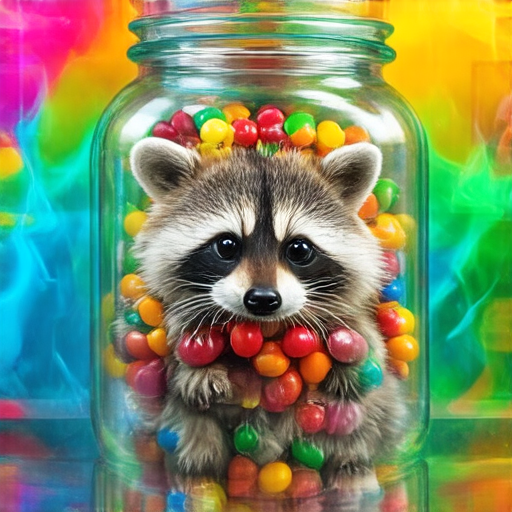

In [15]:
image = ov_pipe(
    "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors",
    negative_prompt="",
    num_inference_steps=28 if not use_flash_lora.value else 4,
    guidance_scale=5 if not use_flash_lora.value else 0,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(141),
).images[0]
image

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `OVStableDiffusion3Pipeline` structure, the `transformer` model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy. That's why we use 4-bit weight compression for the rest of the pipeline to reduce memory footprint.

Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [17]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

optimized_pipe = None

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`google-research-datasets/conceptual_captions`](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data. We use prompts below to guide image generation and to determine what not to include in the resulting image.

In [32]:
%%skip not $to_quantize.value

TRANSFORMER_INT8_PATH = MODEL_DIR / "transformer_int8.xml"
TEXT_ENCODER_INT4_PATH = MODEL_DIR / "text_encoder_int4.xml"
TEXT_ENCODER_2_INT4_PATH = MODEL_DIR / "text_encoder_2_int4.xml"
VAE_DECODER_INT4_PATH = MODEL_DIR / "vae_decoder_int4.xml"
TEXT_ENCODER_3_INT4_PATH = MODEL_DIR / "text_encoder_3_int4.xml" if TEXT_ENCODER_3_PATH.exists() else None

negative_prompts = [
    "blurry unreal occluded",
    "low contrast disfigured uncentered mangled",
    "amateur out of frame low quality nsfw",
    "ugly underexposed jpeg artifacts",
    "low saturation disturbing content",
    "overexposed severe distortion",
    "amateur NSFW",
    "ugly mutilated out of frame disfigured",
]

To collect intermediate model inputs for calibration we should customize `CompiledModel`. We should set the height and width of the image to 512 to reduce memory consumption during quantization.

In [19]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List

set_seed(42)

def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {'disable': disable}
    else:
        pipeline._progress_bar_config['disable'] = disable


class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None, keep_prob: float = 0.5):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache is not None else []
        self.keep_prob = keep_prob

    def __call__(self, *args, **kwargs):
        if np.random.rand() <= self.keep_prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)


def collect_calibration_data(ov_pipe, calibration_dataset_size: int, num_inference_steps: int) -> List[Dict]:
    original_model = ov_pipe.transformer
    calibration_data = []
    ov_pipe.transformer = CompiledModelDecorator(original_model, calibration_data, keep_prob=1)
    disable_progress_bar(ov_pipe)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True, streaming=True)
    size = int(calibration_dataset_size // num_inference_steps)
    dataset = dataset.shuffle(seed=42).take(size)

    # Run inference for data collection
    pbar = tqdm(total=size)
    for batch in dataset:
        prompt = batch["caption"]
        negative_prompt = np.random.choice(negative_prompts)
        ov_pipe(
            prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=5 if not use_flash_lora.value else 0,
            height=512,
            width=512
        )
        if len(calibration_data) >= calibration_dataset_size:
            pbar.update(calibration_dataset_size - pbar.n)
            break
        pbar.update(len(calibration_data) - pbar.n)

    disable_progress_bar(ov_pipe, disable=False)
    ov_pipe.transformer = original_model
    return calibration_data

### Run Quantization
[back to top ⬆️](#Table-of-contents:)

Quantization of the first `Convolution` layer impacts the generation results. We recommend using `IgnoredScope` to keep accuracy sensitive layers in FP16 precision.

In [ ]:
%%skip not $to_quantize.value

import nncf
from transformers import set_seed

if not TRANSFORMER_INT8_PATH.exists():
    calibration_dataset_size = 200
    unet_calibration_data = collect_calibration_data(ov_pipe,
                                                     calibration_dataset_size=calibration_dataset_size,
                                                     num_inference_steps=28 if not use_flash_lora.value else 4)

    transformer = core.read_model(TRANSFORMER_PATH)
    quantized_model = nncf.quantize(
        model=transformer,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        subset_size=calibration_dataset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        ignored_scope=nncf.IgnoredScope(names=["__module.model.base_model.model.pos_embed.proj.base_layer/aten::_convolution/Convolution"]),
    )

    ov.save_model(quantized_model, TRANSFORMER_INT8_PATH)

### Run Weights Compression
[back to top ⬆️](#Table-of-contents:)

Quantizing of the `Text Encoders` and `Autoencoder` does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

In [21]:
%%skip not $to_quantize.value

def compress_model(model_path, save_path):
    if not save_path.exists():
        model = core.read_model(model_path)
        compressed_model = nncf.compress_weights(model, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8)
        ov.save_model(compressed_model, save_path)

In [33]:
%%skip not $to_quantize.value

compress_model(TEXT_ENCODER_PATH, TEXT_ENCODER_INT4_PATH)
compress_model(TEXT_ENCODER_2_PATH, TEXT_ENCODER_2_INT4_PATH)
compress_model(VAE_DECODER_PATH, VAE_DECODER_INT4_PATH)
if TEXT_ENCODER_3_PATH.exists():
    compress_model(TEXT_ENCODER_3_PATH, TEXT_ENCODER_3_INT4_PATH)

Let's compare the images generated by the original and optimized pipelines.

In [34]:
%%skip not $to_quantize.value

optimized_transformer = core.compile_model(TRANSFORMER_INT8_PATH, device.value)
optimized_vae_model = core.compile_model(VAE_DECODER_INT4_PATH, device.value)
optimized_text_encoder = core.compile_model(TEXT_ENCODER_INT4_PATH, device.value)
optimized_text_encoder_2 = core.compile_model(TEXT_ENCODER_2_INT4_PATH, device.value)
optimized_text_encoder_3 = core.compile_model(TEXT_ENCODER_3_INT4_PATH, device.value) if TEXT_ENCODER_3_PATH.exists() else None

In [35]:
%%skip not $to_quantize.value

optimized_pipe = OVStableDiffusion3Pipeline(
    optimized_transformer,
    scheduler,
    optimized_vae_model,
    optimized_text_encoder,
    tokenizer,
    optimized_text_encoder_2,
    tokenizer_2,
    optimized_text_encoder_3,
    tokenizer_3
)

In [36]:
%%skip not $to_quantize.value

import matplotlib.pyplot as plt

def visualize_results(orig_img, optimized_img):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 models
       optimized_img (Image.Image): generated image using quantized models
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 pipeline"
    control_title = "INT8 pipeline"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()

  0%|          | 0/4 [00:00<?, ?it/s]

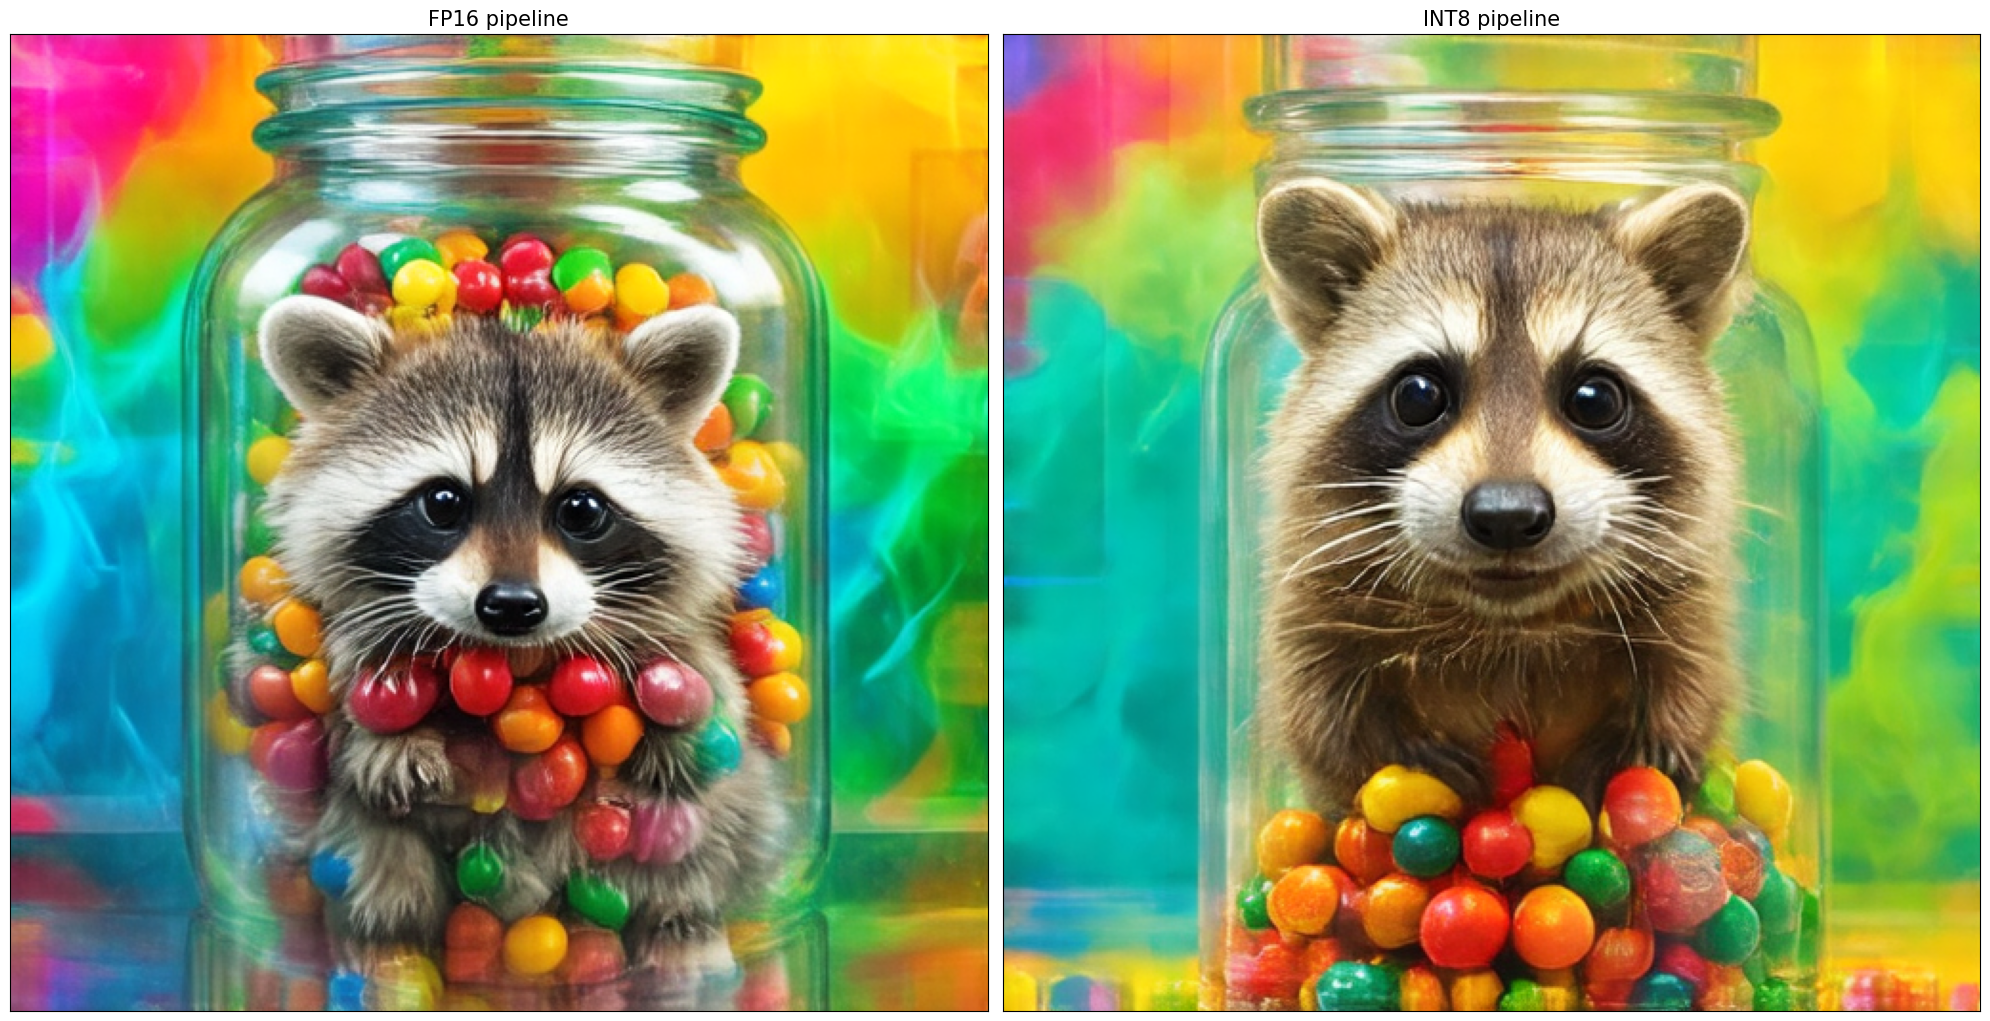

In [37]:
%%skip not $to_quantize.value

opt_image = optimized_pipe(
    "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors",
    negative_prompt="",
    num_inference_steps=28 if not use_flash_lora.value else 4,
    guidance_scale=5 if not use_flash_lora.value else 0,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(141),
).images[0]

visualize_results(image, opt_image)

### Compare model file sizes
[back to top ⬆️](#Table-of-contents:)

In [38]:
%%skip not $to_quantize.value

fp16_model_paths = [TRANSFORMER_PATH, TEXT_ENCODER_PATH, TEXT_ENCODER_2_PATH, TEXT_ENCODER_3_PATH, VAE_DECODER_PATH]
optimized_models = [TRANSFORMER_INT8_PATH, TEXT_ENCODER_INT4_PATH, TEXT_ENCODER_2_INT4_PATH, TEXT_ENCODER_3_INT4_PATH, VAE_DECODER_INT4_PATH]

for fp16_path, optimized_path in zip(fp16_model_paths, optimized_models):
    if not fp16_path.exists():
        continue
    fp16_ir_model_size = fp16_path.with_suffix(".bin").stat().st_size
    optimized_model_size = optimized_path.with_suffix(".bin").stat().st_size
    print(f"{fp16_path.stem} compression rate: {fp16_ir_model_size / optimized_model_size:.3f}")

transformer compression rate: 1.939
text_encoder compression rate: 2.705
text_encoder_2 compression rate: 3.068
vae_decoder compression rate: 2.007


### Compare inference time of the FP16 and optimized pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and optimized pipelines, we use mean inference time on 5 samples.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [39]:
%%skip not $to_quantize.value

import time

def calculate_inference_time(pipeline, validation_data):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    for prompt in validation_data:
        start = time.perf_counter()
        _ = pipeline(
            prompt,
            negative_prompt="",
            num_inference_steps=28 if not use_flash_lora.value else 4,
            guidance_scale=5 if not use_flash_lora.value else 0,
            height=512,
            width=512,
            generator=torch.Generator().manual_seed(141),
        ).images[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [40]:
%%skip not $to_quantize.value

validation_size = 5
validation_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", streaming=True, trust_remote_code=True)
validation_dataset = validation_dataset.take(validation_size)
validation_data = [batch["caption"] for batch in validation_dataset]

fp_latency = calculate_inference_time(ov_pipe, validation_data)
opt_latency = calculate_inference_time(optimized_pipe, validation_data)
print(f"Performance speed-up: {fp_latency / opt_latency:.3f}")

Performance speed-up: 1.494


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized models to launch the interactive demo.

In [ ]:
quantized_models_present = optimized_pipe is not None

use_quantized_models = widgets.Checkbox(
    value=quantized_models_present,
    description="Use quantized models",
    disabled=not quantized_models_present,
)

use_quantized_models

In [ ]:
import gradio as gr
import numpy as np
import random

MAX_SEED = np.iinfo(np.int32).max
MAX_IMAGE_SIZE = 1344
pipeline = optimized_pipe if use_quantized_models.value else ov_pipe


def infer(prompt, negative_prompt, seed, randomize_seed, width, height, guidance_scale, num_inference_steps, progress=gr.Progress(track_tqdm=True)):
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)

    generator = torch.Generator().manual_seed(seed)

    image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        width=width,
        height=height,
        generator=generator,
    ).images[0]

    return image, seed


examples = [
    "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "An astronaut riding a green horse",
    "A delicious ceviche cheesecake slice",
    "A panda reading a book in a lush forest.",
    "A 3d render of a futuristic city with a giant robot in the middle full of neon lights, pink and blue colors",
    'a wizard kitten holding a sign saying "openvino" with a magic wand.',
    "photo of a huge red cat with green eyes sitting on a cloud in the sky, looking at the camera",
    "Pirate ship sailing on a sea with the milky way galaxy in the sky and purple glow lights",
]

css = """
#col-container {
    margin: 0 auto;
    max-width: 580px;
}
"""

with gr.Blocks(css=css) as demo:
    with gr.Column(elem_id="col-container"):
        gr.Markdown(
            """
        # Demo [Stable Diffusion 3 Medium](https://huggingface.co/stabilityai/stable-diffusion-3-medium) with OpenVINO
        """
        )

        with gr.Row():
            prompt = gr.Text(
                label="Prompt",
                show_label=False,
                max_lines=1,
                placeholder="Enter your prompt",
                container=False,
            )

            run_button = gr.Button("Run", scale=0)

        result = gr.Image(label="Result", show_label=False)

        with gr.Accordion("Advanced Settings", open=False):
            negative_prompt = gr.Text(
                label="Negative prompt",
                max_lines=1,
                placeholder="Enter a negative prompt",
            )

            seed = gr.Slider(
                label="Seed",
                minimum=0,
                maximum=MAX_SEED,
                step=1,
                value=0,
            )

            randomize_seed = gr.Checkbox(label="Randomize seed", value=True)

            with gr.Row():
                width = gr.Slider(
                    label="Width",
                    minimum=256,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=512,
                )

                height = gr.Slider(
                    label="Height",
                    minimum=256,
                    maximum=MAX_IMAGE_SIZE,
                    step=64,
                    value=512,
                )

            with gr.Row():
                guidance_scale = gr.Slider(
                    label="Guidance scale",
                    minimum=0.0,
                    maximum=10.0 if not use_flash_lora.value else 2,
                    step=0.1,
                    value=5.0 if not use_flash_lora.value else 0,
                )

                num_inference_steps = gr.Slider(
                    label="Number of inference steps",
                    minimum=1,
                    maximum=50,
                    step=1,
                    value=28 if not use_flash_lora.value else 4,
                )

        gr.Examples(examples=examples, inputs=[prompt])
    gr.on(
        triggers=[run_button.click, prompt.submit, negative_prompt.submit],
        fn=infer,
        inputs=[prompt, negative_prompt, seed, randomize_seed, width, height, guidance_scale, num_inference_steps],
        outputs=[result, seed],
    )

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)